
# Deep Learning with CNNs (David Nallapu - 001530978)

Abstract : Deep Learning with CNNs is an effective to classsify images of dogs based on their breeds. This study aims to classify dog breeds. Hyperparameter tuning will be done to understand the performance of the hyperparameters. This study looks at the impact of changing the actiovation function, cost function, no. of epochs, gradient estimation, network architecture, network initialization. We will see loss, accuracy and other metrics on TensorBoard to understand performance . We will also see that certain paramerter tuning causes a dramatic difference. The findings from this study indicate that it is important to do hyper parameter tuning for Deep Learning with CNNs.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import torchvision
from torch.utils.tensorboard import SummaryWriter
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Data directory
data_dir = os.path.abspath("dog_breeds_cnn.ipynb")[:-len("dog_breeds_cnn.ipynb")]

#Applying Transformation
train_transforms = transforms.Compose([
                                    transforms.Resize(32),
                                      transforms.CenterCrop(32),
                                transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize(32),
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(data_dir + 'data/train',  
                                    transform=train_transforms)                                       
test_data = datasets.ImageFolder(data_dir + 'data/test', 
                                    transform=test_transforms)

In [3]:
#Creating loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

torch.Size([32, 3, 32, 32])

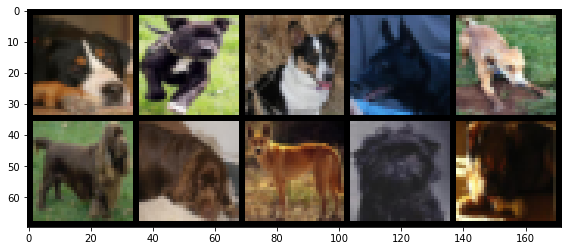

In [4]:
#Viewing the images
for images,labels in train_loader:
    break
im = make_grid(images[0:10], nrow= 5) 
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))
images.shape

In [5]:
class Network(nn.Module):
    def __init__ (self, af, weights_init, hd_layers):
        super().__init__()
        self.af=af
        self.weights_init=weights_init
        self.hd_layers = hd_layers
        self.conv1 = nn.Conv2d(in_channels = 3,out_channels = 5,kernel_size = 5) 
        
        if weights_init=='xavier':
            torch.nn.init.xavier_uniform(self.conv1.weight)
        self.conv2 = nn.Conv2d(in_channels = 5,out_channels = 20,kernel_size = 3)         
        
        if self.hd_layers == 3:
            self.fc1 = nn.Linear(720,360)
            self.fc2 = nn.Linear(360,240)
            self.fc3 = nn.Linear(240,120)
        else:
            self.fc1 = nn.Linear(720,480)
            self.fc2 = nn.Linear(480,360)
            self.fc3 = nn.Linear(360,240)
            self.fc4 = nn.Linear(240,120)

    def forward(self,x):
        if self.af=='relu':
            x = F.relu(self.conv1(x))
            x = F.max_pool2d(x,2,2)
            x = F.relu(self.conv2(x))  
            x = F.max_pool2d(x,2,2)
            #Flattening
            x = x.view(-1,torch.prod(torch.tensor(x.shape[1:])).item())        

            x = F.relu(self.fc1(x))        
            x = F.relu(self.fc2(x))  
            x = F.log_softmax(self.fc3(x),dim = 1)    
            return(x)
        else:
            x = F.leaky_relu(self.conv1(x))
            x = F.max_pool2d(x,2,2)
            x = F.leaky_relu(self.conv2(x))  
            x = F.max_pool2d(x,2,2)

            x = x.view(-1,torch.prod(torch.tensor(x.shape[1:])).item())        

            x = F.leaky_relu(self.fc1(x))        
            x = F.leaky_relu(self.fc2(x))  
            x = F.log_softmax(self.fc3(x),dim = 1)    
            return(x)
            

In [6]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [9]:
from itertools import product

parameters = dict(
    af = ['relu','leaky_relu'],
    cf = ['cross_entropy','nll_loss'],
    epochs = [5,10],
    ge = ['adam'],
    hd_layers = [3,4],
    weights = ['default','xavier']
)

param_values = [v for v in parameters.values()]

for af,cf,epochs,ge,hd_layers,weights in product(*param_values):
    network = Network(af , weights, hd_layers)
    images, labels = next(iter(train_loader))
    grid = torchvision.utils.make_grid(images)
    comment = f' af={af} cf={cf} epochs={epochs} ge ={ge} weights = {weights}'
    tb = SummaryWriter(comment=comment)
    tb.add_image('images',grid)
    tb.add_graph(network,images)
    lr = 0.001
    
    if(ge=='adam'):
        optimizer = torch.optim.Adam(network.parameters(), lr = lr)
    else:
        optimizer = torch.optim.SGD(network.parameters(), lr = lr)
    print("Activation:",af,"Cost:",cf,"Epochs:",epochs,"Gradient:",ge,"Hidden layers:",hd_layers, "Weights:",weights)    
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_accuracy = 0
        b_num = 0#no. of batches
        # Run the training batches
        for batch in train_loader:
            b_num+=1
            images,labels = batch  

            # Apply the model
            preds = network(images)
            
            if cf =='nll_loss':
                loss = F.cross_entropy(preds,labels)#Calculating loss
            else:
                loss = F.nll_loss(preds,labels)

            # Updating parameters
            optimizer.zero_grad()
            loss.backward()#Calculating gradients
            optimizer.step()#Updating weights
                
            
            total_loss+=loss.item()
            total_correct+=get_num_correct(preds,labels)
            total_accuracy+=get_num_correct(preds,labels)/len(preds)

        tb.add_scalar("Loss", total_loss, epoch)
        tb.add_scalar("Correct", total_correct, epoch)
        tb.add_scalar("Accuracy", (total_accuracy/b_num)*100)

        tb.add_histogram("conv1.bias", network.conv1.bias, epoch)
        tb.add_histogram("conv1.weight", network.conv1.weight, epoch)
        tb.add_histogram("conv2.bias", network.conv2.bias, epoch)
        tb.add_histogram("conv2.weight", network.conv2.weight, epoch)

        print("epoch:", epoch, "total_correct:", total_correct, "loss:",total_loss,"accuracy:",(total_accuracy/b_num)*100)
    print()
tb.close()

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a c

Activation: relu Cost: cross_entropy Epochs: 5 Gradient: adam Hidden layers: 3 Weights: default
epoch: 0 total_correct: 225 loss: 1741.350920677185 accuracy: 7.03125
epoch: 1 total_correct: 315 loss: 1669.613347530365 accuracy: 9.84375
epoch: 2 total_correct: 435 loss: 1632.194804906845 accuracy: 13.59375
epoch: 3 total_correct: 559 loss: 1590.1615221500397 accuracy: 17.46875
epoch: 4 total_correct: 718 loss: 1545.3969502449036 accuracy: 22.4375

Activation: relu Cost: cross_entropy Epochs: 5 Gradient: adam Hidden layers: 3 Weights: xavier


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  # Remove the CWD from sys.path while we load stuff.


epoch: 0 total_correct: 269 loss: 1709.4543781280518 accuracy: 8.40625
epoch: 1 total_correct: 563 loss: 1585.6569883823395 accuracy: 17.59375
epoch: 2 total_correct: 710 loss: 1548.2683749198914 accuracy: 22.1875
epoch: 3 total_correct: 858 loss: 1505.7783153057098 accuracy: 26.8125
epoch: 4 total_correct: 1014 loss: 1469.952172279358 accuracy: 31.6875

Activation: relu Cost: cross_entropy Epochs: 5 Gradient: adam Hidden layers: 4 Weights: default
epoch: 0 total_correct: 151 loss: 1783.8630928993225 accuracy: 4.71875
epoch: 1 total_correct: 413 loss: 1639.214174747467 accuracy: 12.90625
epoch: 2 total_correct: 600 loss: 1573.0940825939178 accuracy: 18.75
epoch: 3 total_correct: 740 loss: 1534.8544380664825 accuracy: 23.125
epoch: 4 total_correct: 877 loss: 1495.8961699008942 accuracy: 27.40625

Activation: relu Cost: cross_entropy Epochs: 5 Gradient: adam Hidden layers: 4 Weights: xavier
epoch: 0 total_correct: 175 loss: 1773.2507162094116 accuracy: 5.46875
epoch: 1 total_correct: 440

epoch: 4 total_correct: 999 loss: 1467.3179156780243 accuracy: 31.21875
epoch: 5 total_correct: 1270 loss: 1423.5930252075195 accuracy: 39.6875
epoch: 6 total_correct: 1447 loss: 1374.921539068222 accuracy: 45.21875
epoch: 7 total_correct: 1752 loss: 1324.0946972370148 accuracy: 54.75
epoch: 8 total_correct: 2012 loss: 1270.6097900867462 accuracy: 62.875
epoch: 9 total_correct: 2387 loss: 1208.2923862934113 accuracy: 74.59375

Activation: relu Cost: nll_loss Epochs: 10 Gradient: adam Hidden layers: 4 Weights: xavier
epoch: 0 total_correct: 135 loss: 1808.0806555747986 accuracy: 4.21875
epoch: 1 total_correct: 312 loss: 1687.286714553833 accuracy: 9.75
epoch: 2 total_correct: 453 loss: 1631.8128373622894 accuracy: 14.15625
epoch: 3 total_correct: 553 loss: 1586.991156578064 accuracy: 17.28125
epoch: 4 total_correct: 734 loss: 1544.1422879695892 accuracy: 22.9375
epoch: 5 total_correct: 852 loss: 1509.5802164077759 accuracy: 26.625
epoch: 6 total_correct: 1078 loss: 1469.1362500190735 ac

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a c

epoch: 0 total_correct: 235 loss: 1730.5143194198608 accuracy: 7.34375
epoch: 1 total_correct: 467 loss: 1619.4327702522278 accuracy: 14.59375
epoch: 2 total_correct: 670 loss: 1552.904725074768 accuracy: 20.9375
epoch: 3 total_correct: 818 loss: 1507.2511076927185 accuracy: 25.5625
epoch: 4 total_correct: 1079 loss: 1454.5859005451202 accuracy: 33.71875

Activation: leaky_relu Cost: cross_entropy Epochs: 5 Gradient: adam Hidden layers: 3 Weights: xavier
epoch: 0 total_correct: 278 loss: 1714.9952235221863 accuracy: 8.6875
epoch: 1 total_correct: 599 loss: 1576.748527288437 accuracy: 18.71875
epoch: 2 total_correct: 822 loss: 1518.947830438614 accuracy: 25.6875
epoch: 3 total_correct: 1030 loss: 1466.336377620697 accuracy: 32.1875
epoch: 4 total_correct: 1326 loss: 1411.4412937164307 accuracy: 41.4375

Activation: leaky_relu Cost: cross_entropy Epochs: 5 Gradient: adam Hidden layers: 4 Weights: default
epoch: 0 total_correct: 245 loss: 1756.774751663208 accuracy: 7.65625
epoch: 1 total

epoch: 7 total_correct: 2525 loss: 1186.228042125702 accuracy: 78.90625
epoch: 8 total_correct: 3230 loss: 1073.0512881278992 accuracy: 100.9375
epoch: 9 total_correct: 4100 loss: 944.7796968221664 accuracy: 128.125

Activation: leaky_relu Cost: nll_loss Epochs: 10 Gradient: adam Hidden layers: 4 Weights: default
epoch: 0 total_correct: 135 loss: 1805.889335155487 accuracy: 4.21875
epoch: 1 total_correct: 443 loss: 1625.7343635559082 accuracy: 13.84375
epoch: 2 total_correct: 695 loss: 1542.7933747768402 accuracy: 21.71875
epoch: 3 total_correct: 969 loss: 1479.3026034832 accuracy: 30.28125
epoch: 4 total_correct: 1345 loss: 1405.3847494125366 accuracy: 42.03125
epoch: 5 total_correct: 1793 loss: 1316.221678495407 accuracy: 56.03125
epoch: 6 total_correct: 2342 loss: 1213.6066181659698 accuracy: 73.1875
epoch: 7 total_correct: 3170 loss: 1084.8269891738892 accuracy: 99.0625
epoch: 8 total_correct: 4162 loss: 928.9839693307877 accuracy: 130.0625
epoch: 9 total_correct: 5611 loss: 749.36

In [25]:
from itertools import product

parameters = dict(
    af = ['leaky-relu'],
    cf = ['nll_loss'],
    epochs = [30],
    ge = ['adam'],
    hd_layers = [4],
    weights = ['default']
)

param_values = [v for v in parameters.values()]

for af,cf,epochs,ge,hd_layers,weights in product(*param_values):
    network = Network(af , weights, hd_layers)
    images, labels = next(iter(train_loader))
    grid = torchvision.utils.make_grid(images)
    comment = f' af={af} cf={cf} epochs={epochs} ge ={ge} weights = {weights}'
    lr = 0.001
    
    if(ge=='adam'):
        optimizer = torch.optim.Adam(network.parameters(), lr = lr)
    else:
        optimizer = torch.optim.SGD(network.parameters(), lr = lr)
    print("Activation:",af,"Cost:",cf,"Epochs:",epochs,"Gradient:",ge,"Hidden layers:",hd_layers, "Weights:",weights)    
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_accuracy = 0
        # Run the training batches
        b_num = 0#no. of batches
        for batch in train_loader:
            b_num+=1
            images,labels = batch  
            # Apply the model
            preds = network(images)
            if cf =='nll_loss':
                loss = F.cross_entropy(preds,labels)#Calculating loss
            else:
                loss = F.nll_loss(preds,labels)

            # Updating parameters
            optimizer.zero_grad()
            loss.backward()#Calculating gradients
            optimizer.step()#Updating weights
            
            total_loss+=loss.item()
            total_correct+=get_num_correct(preds,labels)
            total_accuracy+=get_num_correct(preds,labels)/len(preds)
        
        print("epoch:", epoch, "total_correct:", total_correct, "loss:",total_loss,"accuracy:",(total_accuracy/b_num)*100)
    print()
tb.close()

Activation: leaky-relu Cost: nll_loss Epochs: 30 Gradient: adam Hidden layers: 4 Weights: default
epoch: 0 total_correct: 239 loss: 1757.207245349884 accuracy: 1.9916666666666667
epoch: 1 total_correct: 506 loss: 1610.99156498909 accuracy: 4.216666666666667
epoch: 2 total_correct: 695 loss: 1551.6614603996277 accuracy: 5.791666666666666
epoch: 3 total_correct: 892 loss: 1501.9595692157745 accuracy: 7.433333333333334
epoch: 4 total_correct: 1102 loss: 1446.5345504283905 accuracy: 9.183333333333334
epoch: 5 total_correct: 1392 loss: 1385.9072828292847 accuracy: 11.600000000000001
epoch: 6 total_correct: 1794 loss: 1312.306798696518 accuracy: 14.95
epoch: 7 total_correct: 2320 loss: 1224.8027143478394 accuracy: 19.333333333333332
epoch: 8 total_correct: 2894 loss: 1115.271402835846 accuracy: 24.116666666666667
epoch: 9 total_correct: 3841 loss: 987.6448740959167 accuracy: 32.00833333333333
epoch: 10 total_correct: 4861 loss: 837.7478649616241 accuracy: 40.50833333333333
epoch: 11 total_co

### Changing the activation function

Leaky-relu performs better than relu from our study

### Changing the cost function
NLL-Loss alogirthm does better than cross-entropy from our study

### Changing the number of epochs

Increasing from 5 to 10 has increased the accuracy. There is no plateuing at this point. 
We can see that after 30 epochs it doesnt cross 98.04% accuracy with chosen hyperparameters

### Changing the gradient estimation

Adam seems to always do better than stochasatic gradient here. Stochastic Gradient's loss seems to be constant hence I'm not running it in my simulation.

### Changing the network architecture

Increasing the no. of hidden layers from 3 to 4 increases the accuracy to a large extent for this problem.

### Changing the network initialization

Xavier leads to an increase in accuracy compared to the default torch init in the start of most simulations. The deault weights init does catch up eventually and performs better.

## Conclusion
We can conclude that hyperparameters are paramount in CNNs.Leaky-relu performs better than relu from our study. NLL-Loss alogirthm does better than cross-entropy from our study. Increasing from 5 to 10 has increased the accuracy. There is no plateuing at this point. Simulation needs to be run for more epochs on a faster cpu for more information. Adam optimizer seems to always do better than stochasatic gradient here. Stochastic Gradient's loss seems to be constant hence I'm not running it in my simulation.Increasing the no. of hidden layers from 3 to 4 increases the accuracy to a large extent for this problem. Xavier weights initialization leads to an increase in accuracy compared to the default torch init in most simulations. We achieve an accuracy of 96.7% accuracy over 21 epochs with Leaky-Relu, Adam Optimizitation, and NLL Loss with 4 hidden layers.

## References
[1]: Dataset : https://www.kaggle.com/miljan/stanford-dogs-dataset-traintest#

[2]: CNN : https://www.datacamp.com/community/tutorials/cnn-tensorflow-python 

[3]: PyTorch : https://medium.com/@thinkai.org/using-pytorch-for-building-a-convolutional-neural-network-cnn-model-6e47ffb61b88

[4]: Classification : https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

[5]: Classification :https://becominghuman.ai/building-a-convolutional-neural-network-cnn-model-for-image-classification-116f77a7a236

## Licensing

Copyright 2021 David Samuel Nallapu
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.